In [1]:
"""Created on Fri Nov 9 17:54:16 2018

@author: kurtb

@inproceedings{memisevic2005multiple,
  title={Multiple relational embedding},
  author={Memisevic, Roland and Hinton, Geoffrey E},
  booktitle={Advances in neural information processing systems},
  pages={913--920},
  year={2005}
}

Note X and Y are X' and Y' in paper

"""
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import glob
import scipy
import scipy.misc
from scipy.optimize import minimize
import time
from mpl_toolkits.mplot3d import Axes3D


In [2]:
# %% functions

def similarity(v1,v2,sigma=1):
    ''' when sigma=1, proportional to squared euclidean.
    when sigma=kernel_bandwidth -> SNE
    
    (numerator in eqs. 1 and 2)'''
    return np.exp( - np.divide(1.,sigma**2) * np.linalg.norm(v1-v2)**2)


def similarity_matrix(Y,sigma=1):
    '''eqs. 1 and 2
    Y: N*ft matrix. 
    sigma:neighborhood variance/ kernel bandwidth'''
    m = np.zeros((Y.shape[0],Y.shape[0]))
    for i in range(Y.shape[0]):
        den = np.sum([similarity(Y[i,:],Y[k,:], sigma) for k in range(Y.shape[0])])
        for j in range(Y.shape[0]):
            num = similarity(Y[i,:],Y[j,:], sigma)
            m[i,j] = np.divide(num,den)
    return m


def calc_Qc(Rc,X):
    '''Rc is diagonal, X is shared reduced space proposal, we calc squared 
    euclidean rather than SNE'''
    RcX = np.dot(X,Rc)
    Qc = similarity_matrix(RcX,sigma=1)
    for i in range(Qc.shape[0]):
        Qc[i,:] = [Qc[i,j]/np.sum(Qc[i,:]) for j in range(Qc.shape[1])]
    return Qc
    

def KL(Pc,Qc):
    """ Epsilon added so no Qc is 0.
    
    from Q to P.. the amount of information lost when Q is used to approximate P"""
    epsilon = 0.00001

    vPc = Pc.flatten()+epsilon
    vQc = Qc.flatten()+epsilon
 
    return np.sum((vPc*np.log(vPc/vQc)))


def calc_Ec(Pc,Qc):
    '''KL-divergence between matrices Pc and Qc '''
    assert(np.allclose(np.sum(Qc,axis=1),1))
    assert(np.allclose(np.sum(Pc,axis=1),1))
    return KL(Pc,Qc)
    
    
def calc_E(vRcX,P,ndim):
    '''P: dictionary of similarity matrices'''
    mRcX = np.reshape(vRcX,(P['LL'].shape[0]+len(P),ndim))
    X = mRcX[len(P):,:]
    
    plot3d(X)
    Ecs = []
    for i,(n,Pc) in enumerate(P.items()):
        Rc = np.diag(mRcX[i,:])
        Qc = calc_Qc(Rc,X)
        Ecs.append(calc_Ec(Pc,Qc))
    sumLec = np.sum(Ecs)
#     print(sumLec)
    return sumLec#+penalty


def colorbar():
    plt.colorbar(fraction=0.046, pad=0.04)
    

<IPython.core.display.Javascript object>


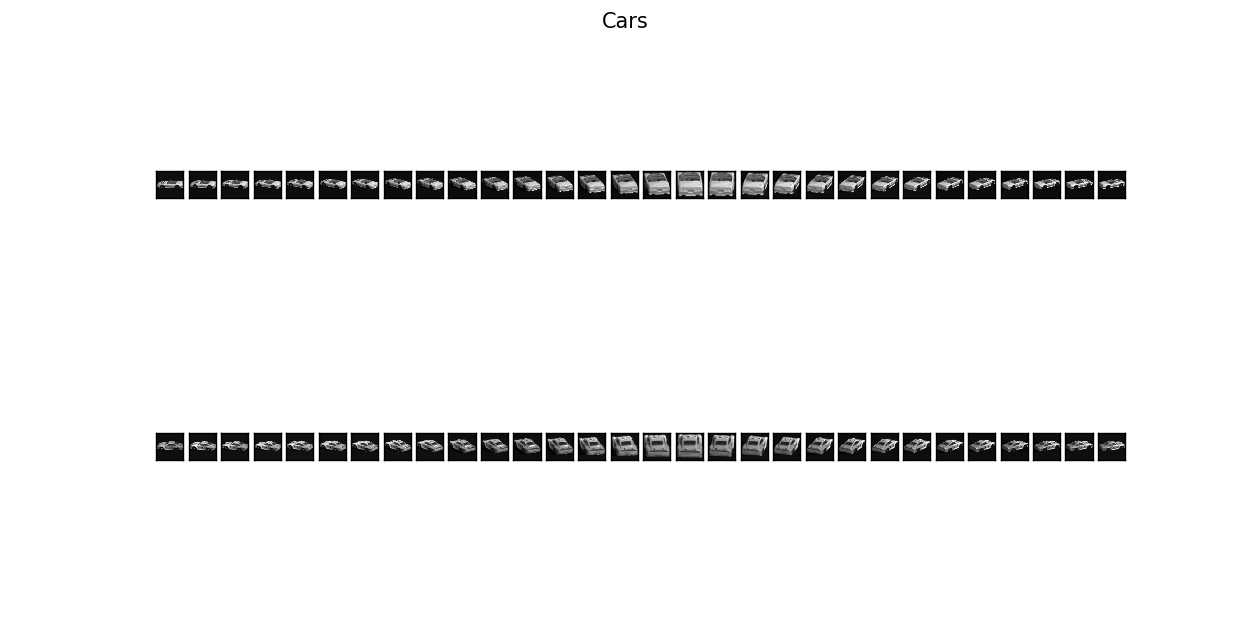

/home/kurtb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/kurtb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


[69, 8]


<IPython.core.display.Javascript object>


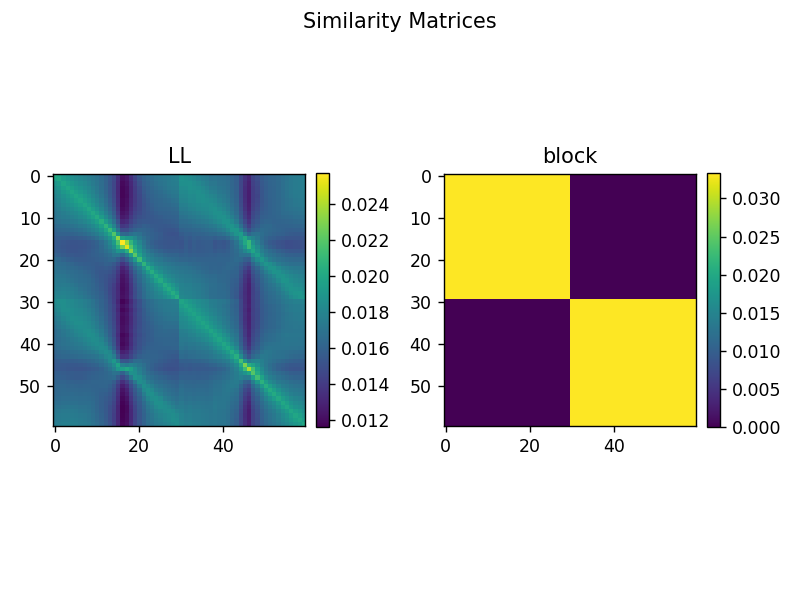

In [3]:
#%% create "P"
plots       = [True,True] #[cars, similarityMatrices]
save        = False
nCars       = 2
firstView   = 2
nViews      = 30

timeMarker = time.strftime("%Y%m%d-%H%M%S")

plt.close('all')
if plots[0]:
    plt.figure(figsize=(10,5))
    
carNumbs = [69,8,15,19,23,27,6,76,91,100,][:nCars] 
f = 'coil-100_grey'
resf = 'res'
imTemplate = scipy.misc.imread('coil-100_grey/obj76__000.png')[:,:,0]

print(carNumbs)

P_LL = np.zeros((nViews*len(carNumbs),nViews*len(carNumbs)))
P_block = scipy.linalg.block_diag(*[np.ones((nViews,nViews))/nViews]*nCars)

i=-1
Y = np.zeros((nViews*len(carNumbs),len(imTemplate.flatten())))
for icar,car in enumerate(carNumbs):
    ps = np.sort(glob.glob(f+'/obj%d_*.png'%car))
    ps = ps[firstView:nViews+firstView]#[2:72:2]
    for ip,p in enumerate(ps):
        i+=1
        im = scipy.misc.imread(p).mean(axis=2)#[:,:,0]
        if plots[0]:
            plt.subplot(nCars,len(ps),i+1);plt.imshow(im,cmap='gray')        
            frame1 = plt.gca()
            frame1.axes.get_xaxis().set_visible(False)
            frame1.axes.get_yaxis().set_visible(False)
        Y[i,:] = im.flatten()

plt.suptitle('Cars')
plt.show()
plt.pause(.01)
if save:
    plt.savefig(resf+'/stim_%s.png'%timeMarker) 
    
P_LL = similarity_matrix(Y,sigma=np.sqrt(5*10**7))

for i in range(P_LL.shape[0]):
    vsum = np.sum(P_LL[i,:])
    P_LL[i,:] = [P_LL[i,j]/np.sum(vsum) for j in range(P_LL.shape[1])]
    P_block[i,:] = [P_block[i,j]/np.sum(P_block[i,:]) for j in range(P_block.shape[1])]
        
                    
assert(P_LL.shape==P_block.shape)
P = {'LL':P_LL,'block':P_block}


if plots[1]:
    plt.figure()
    for i,(n,m) in enumerate(P.items()):
        plt.subplot(1,2,i+1);plt.imshow(m,cmap='viridis'); colorbar(); plt.title(n)

    plt.tight_layout()
    plt.suptitle('Similarity Matrices')
    plt.show()
    plt.pause(.1)

if save:
    plt.savefig(resf+'/P_%s.png'%timeMarker) 
   



<IPython.core.display.Javascript object>


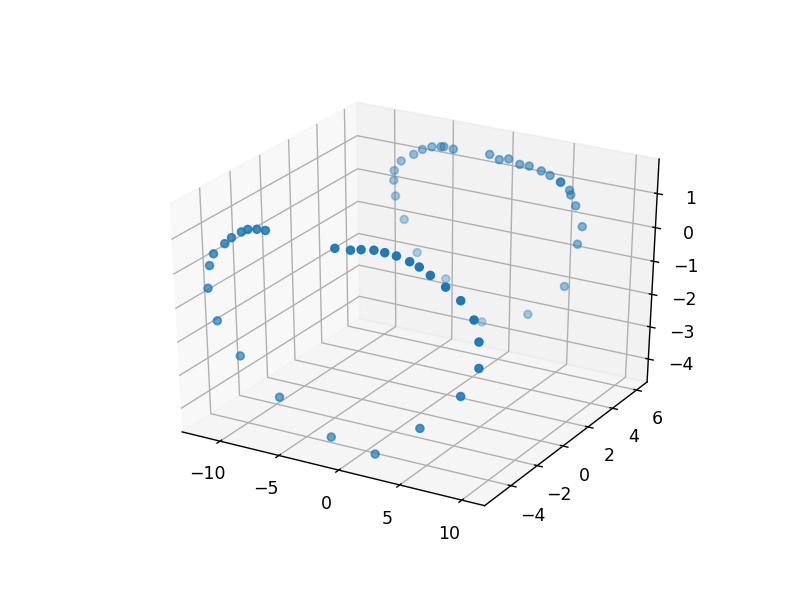

Optimization terminated successfully.
         Current function value: 0.033544
         Iterations: 13
         Function evaluations: 28153


In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.show()
fig.canvas.draw()
def plot3d(X,ax=ax):
    if np.random.rand(1)>.9:
        ax.clear()
        ax.scatter(X[:,0], X[:,1], X[:,2])
        plt.ion()
        fig.canvas.draw()
        fig.show()
        plt.pause(.01)
        
        
#%% fit
ndim = 3 # of latent space
        
vRcX = (1+np.random.randn(P['LL'].shape[0]+len(P),ndim).flatten())*(1/ndim) # random init
#%%
res = minimize(calc_E,vRcX,args=(P,ndim),options={'maxiter':200,'disp':True},
               method='Powell')
